# Partie I
Il s'agit de la partie pratique du DM de Modèles génératifs d'image. Il va consister à mettre en place un WGAN semi-discret, un peu comme dans la fin du TP2. En premier lieu, on va se concentrer sur un exemple académique :
Résoudre le problème suivant, lorsque $\nu = \frac{1}{2} \delta_{y_1} + \frac{1}{2}\delta_{y_2}$, avec $y_1 = (-1, 0)$ et $y_2 = (1,0)$, et $\mu_{\theta}$ la densité de probabilité de la v.a.r $g_{\theta} = aZ + (1 - Z)b$, où $Z \hookrightarrow \mathcal{U}([0,1])$ et $\theta = (a,b) \in (\mathbb{R}^2)^2$.
\begin{equation}
\min\limits_{\theta \in (\mathbb{R}^2)^2} \mathcal{W}(\mu_{\theta}, \nu)
\end{equation}
où $\mathcal{W}$ est la distance de Wassertstein d'ordre 2 i.e $\mathcal{W}(\mu, \nu) = \inf\limits_{\pi \in \mathbb{\Pi}(\mu, \nu)}\displaystyle\int_{\mathcal{X} \times \mathcal{Y}} ||x - y||^2 d\pi(x,y)$, avec $\mathbb{\Pi}(\mu, \nu) = \{\pi \in \mathcal{M}_1^+(\mathcal{X} \times \mathcal{Y}) / \forall f \in \mathcal{C}^0_b(\mathcal{X}), \int_{A\times \mathcal{Y}}fd\pi(x,y) = \int_{A}fd\mu ,\quad \forall g \in \mathcal{C}^0_b(\mathcal{Y}), \int_{\mathcal{X}\times B}g d\pi(x,y) = \int_{B}gd\nu \}$.

On pourrait être tenté de prendre $a_1 = -b_1 = 1$ et $a_2 = b_2 = 0$. Pour $a_1$ et $b_1$, on le comprend car on aimerait éviter les débordement latéraux qui pourraient sembler inutile. La solution numérique contredira notre intuition première, nous en discuterons ultérieurement. Concernant $a_2, b_2$, ajouter de la masse sur l'axe $Oy$ paraîtrait superficielle puisque augmenterait automatiquement une distance supplémentaire. Notre raisonnement s'avèrera dans ce cas bien correct. Il me paraît difficile $\textit{a priori}$ de calculer la solution analytiquement, mais on pourra s'en convaincre assez facilement.

Un point très important à souligner est que calculer $\mathcal{W}$ est déjà en soi un problème d'optimisation. Ainsi, si on veut ésperer résoudre le problème de manière itérative, il faudra à chaque étape calculer $\mathcal{W}(\mu_{\theta^{(n)}}, \nu)$, ce qui peut être coûteux si on n'a pas la bonne approche.

On pourrait donc reformuler le problème comme suit :
\begin{equation}
\min\limits_{\theta \in (\mathbb{R}^2)^2} \mathcal{W}(\mu_{\theta}, \nu) = \min\limits_{\theta \in (\mathbb{R}^2)^2} \min\limits_{\pi \in \mathbb{\Pi}(\mu_{\theta}, \nu)}\displaystyle\int_{\mathcal{X} \times \mathcal{Y}} ||x - y||^2 d\pi(x,y)
\end{equation}

On va en réalité plutôt résoudre le problème dual :
$$
\mathcal{W}(\mu_{\theta}, \nu) = \max\limits_{v \in \mathbb{R}^2} H_{\theta}(v) = \mathbb{E}_{X \sim \mu_{\theta}} [\tilde{H}_{\theta}(v, X)] = \int_{\mathbf{R}^2} v^c(x) \mu_{\theta}(dx) + \sum_{i = 1}^2 v(y_i)\nu_i
$$
avec $\tilde{H}_{\theta}(v, x) = v^c(x) + \sum_i v(y_i)\nu_i$.
Dans notre cas, le problème est simplement :
$$
\max\limits_{v} H_{\theta}(v) = \mathbb{E}_{X \sim \mu_{\theta}} [\tilde{H}(v, X)] = \int_{[b_1,a_1]\times [b_2, a_2]} v^c(x) \mu_{\theta}(dx) + \frac{1}{2}v(y_1) + \frac{1}{2}v(y_2)
$$

On rappelle que ici : $v^c(x) = \min\limits_{i \in \{1, \cdots, J\}} c(x,y_i) - v(y_i) = \min\limits_{i \in \{1,2\}} c(x,y_i) - v(y_i)$


Pour calculer ce premier problème d'optimisation, on va implémenter l'algorithme de gradient de descente stochastique (ASGD). Cela est justifié par le fait que $H_{\theta}$ puisse être écrit comme une esperance et que $H_{\theta}(v)$ est une fonction concave de $v$. Pour utiliser cet algorithme, on doit calculer le gradient de $\tilde{H}_{\theta}(v,x)$. On peut montrer qu'il s'exprime comme $\nabla_v \tilde{H}_{\theta}(v,x) = \nu - \chi_{v^c}$, avec $\chi_{v^c} = \mathbf{e}_{\arg \text{min}_{i \in \{1, 2\}} c(x,y_i) - v(y_i)}$ un vecteur de la base canonique et $\nu = (\frac{1}{2}, \frac{1}{2})$.

On se fixe $\theta = \theta^0$, et on va échantilloner un batch de taille $k$ $B_k$ avec la loi uniforme associée à $\theta$. On calcule ensuite le gradient en chacun des échantillons, puis on les somme. Cependant, pour chaque échantillon, on doit trouver $\arg \text{min}_{i \in \{1, 2\}} c(x,y_i) - v(y_i)$ pour calculer le gradient.

On note $\gamma$ le learning rate. Rappelons que l'on cherche à calculer $v$, qui est dans ce cas là un vecteur de $\mathbb{R}^2$.

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data
import matplotlib.pyplot as plt
from matplotlib import figure
import time
import os
import time

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
      img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cpu


c:\Users\hugon\anaconda3\Lib\site-packages\torch\cuda\__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


ASGD Implementation (Genevay et al., 2016)


![title](img/asgd.PNG)

In [36]:
def dist_quadr(x,y):
    """
    Compute quadratic distance between x and y
    Args :
        x : array of size n
        y = array of size n
    Output :
    ||x - y||^2
    """
    return np.sum((x - y)**2)

#parameters
gamma = 0.2
n = 10000
theta = [[-0.75,0.2], [-0.75, 0.2]] #arbitrary theta, we have theta[0] = a and theta[1] = b
v_tilde = np.zeros(2)
v = np.zeros(2)

#parameters of the problem
y = np.array([[-1,0], [1,0]])
nu = np.array([1/2, 1/2])

for i in range(1, n + 1):
    #We sample x following an uniform law
    a = theta[0]
    b = theta[1]
    x = np.random.uniform(0,1)
    g = np.dot(a,x) + np.dot(1 - x,b)

    j = np.argmin((dist_quadr(g,y[0]) - v_tilde[0], dist_quadr(g,y[1]) - v_tilde[1]))
    one = np.zeros(2)
    one[j] = 1
    grad = nu - one
    v_tilde += gamma/np.sqrt(i)*grad
    v = v_tilde/i + (i - 1)/n*v
print('v* =', v)
v = torch.tensor(v, dtype = torch.float32)

v* = [-0.01889987  0.01889987]


On remarque que les deux composantes de $v$ sont identiques, au signe près. Cela est plutôt bon signe, car on pourrait y reconnaître ici la symétrie original par rapport à l'axe des ordonnées.

Je n'ai pas trouvé de valeur de $\theta$ tels que $v$ soit singular.

---

Pour implémenter ASGD avec pytorch, il faut fournir une fonction dont on veut calculer le gradient. Cette fonction est dans notre cas :
$\tilde{H}_{\theta}$. Je vais échantilloner un x de loi $\mathcal{U}_{\theta}$ pour l'évaluer en ce point. J'espere que asgd.step fera de son côté le process d'en prendre plusieurs.

In [3]:
def c(x,y):
    """
    Compute the squared euclidian distance between x and y
    Args :
      x : Array of size d
      y : Array of size d
    Outputs :
    ||x - y||^2
    """
    return torch.sum((x - y)**2)

def H(theta, v, y, nu, N = 300):
    """
    Compute H i.e the expectation of H_tilde
    Args :
        theta : parameter of the 2D uniform law (float 2 x 2)
        v : point of evalutation of H (float 2 x 1)
        y : Location of the dirac of the discrete measure (float 2 x 1)
        nu : weight of the discrete measure (float 2 x 1)
        N : Number of samples to evaluate the integral (int)
    Outputs :
        Return H(v)
    """
    int_H = 0
    a = theta[0]
    b = theta[1]

    for _ in range(N): #Loop is a bit long, find an alternative if possible
        x = torch.rand(1) #We sample a point in [0,1]
        g = a*x + b*(1 - x)
        l = torch.argmin(torch.tensor([c(g,y[0]) - v[0], c(g,y[1]) - v[1]]))
        v_c = c(g,y[l]) - v[l] #Calculation of the c-transform of v at the sampled point
        int_H = int_H + v_c/N
    return int_H + torch.dot(nu,v)

Calcul de $\max\limits_{v} H(v)$ avec l'ASGD de PyTorch.

In [35]:
n_iter = 2000
N = 300 #number of samples
theta_py = torch.tensor([[-1,-0.5], [-1, -0.5]])

v_py = torch.ones(2, requires_grad=True)
asgd = torch.optim.ASGD([v_py], lr = gamma)

nu_py = torch.tensor([1/2,1/2])
y = torch.tensor([[-1, 0], [1,0]])

for i in range(n_iter):
    asgd.zero_grad()
    loss = - H(theta_py, v_py, y, nu_py)
    loss.backward()
    asgd.step()

print('In PyTorch ASGD')
print('v* = ',v_py)
print('H(v*) = ', H(theta_py, v_py, y, nu_py))
print('\n')

print('My own implementation :')
print('v* =', v)
print('H(v*) =', H(theta_py, v, y, nu_py))

In PyTorch ASGD
v* =  tensor([-0.7951,  2.7181], requires_grad=True)
H(v*) =  tensor(2.4624, grad_fn=<AddBackward0>)


My own implementation :
v* = tensor([ 4.9468e-14, -4.9468e-14])
H(v*) = tensor(0.8431)


On note que contrairement à ce qui a été fait plus haut avec l'ASGD proposé par (Genevay et al., 2016), $v^\star$ n'est ici pas 'anti-symétrique', c'est-à-dire que l'on a pas $v^\star_1 = -v^\star_2$. Cela aurait été apprécié car montre que l'on retrouve dans la solution la symètrie du problème original.

La fonction obectif obtenu $H(v^*)$ est approximativement la même, on n'obtient cependant pas le même $v^*$ dans les deux cas.

---

Pour trouver le minimum de $\mathcal{W}(\mu_{\theta}, \nu)$, on doit implémenter un algorithme descente-montée, un peu à la manière des algorithmes primal-dual. Dans ces algorithmes, résérvés aux problèmes convexes, on introduit la fonction objectif qui est le lagrangien $\mathcal{L}(x,\lambda)$, et on implémente une descente de gradient par rapport à la variable $x$ et une montée de gradient par rapport au multiplicateur $\lambda$. En effet, on sait que la solution vérifie nécessairement $\mathcal{L}(x^\star,\lambda^\star) = \min\limits_{x}\max\limits_{\lambda}\mathcal{L}(x,\lambda) = \max\limits_{\lambda}\min\limits_{x} \mathcal{L}(x, \lambda)$.

Dans notre cas, on a une situation un peu similaire puisqu'il s'agit de résoudre $\min\limits_{\theta} \mathcal{W}(\mu_{\theta}, \nu) = \min\limits_{\theta} \max\limits_{v} H(v)$.
L'ASGD s'occupera de la montée de gradient pour calculer le multiplicateur de lagrange optimal $v^\star$, tandis que pour la descente, on va utiliser un algorithme de descente de gradient classique, ADAM dans ce cas. Pour mettre en place cela, il faut cependant pourvoir calculer le gradient de $\mathcal{W}(\mu_{\theta}, \nu)$ en $\theta$, idéalement avoir une formule analytique.

Fort heureusement, PyTorch va s'occuper du calcul de ce gradient.

![title](img/algo.PNG)

Dans le cas où on se sert de l'ASGD proposé dans le cours :


optimal theta is tensor([[ 1.5349e+00, -1.3700e-12],
        [-1.5170e+00,  1.0545e-12]], requires_grad=True)
optimal v is : tensor([ 0.0040, -0.0040])


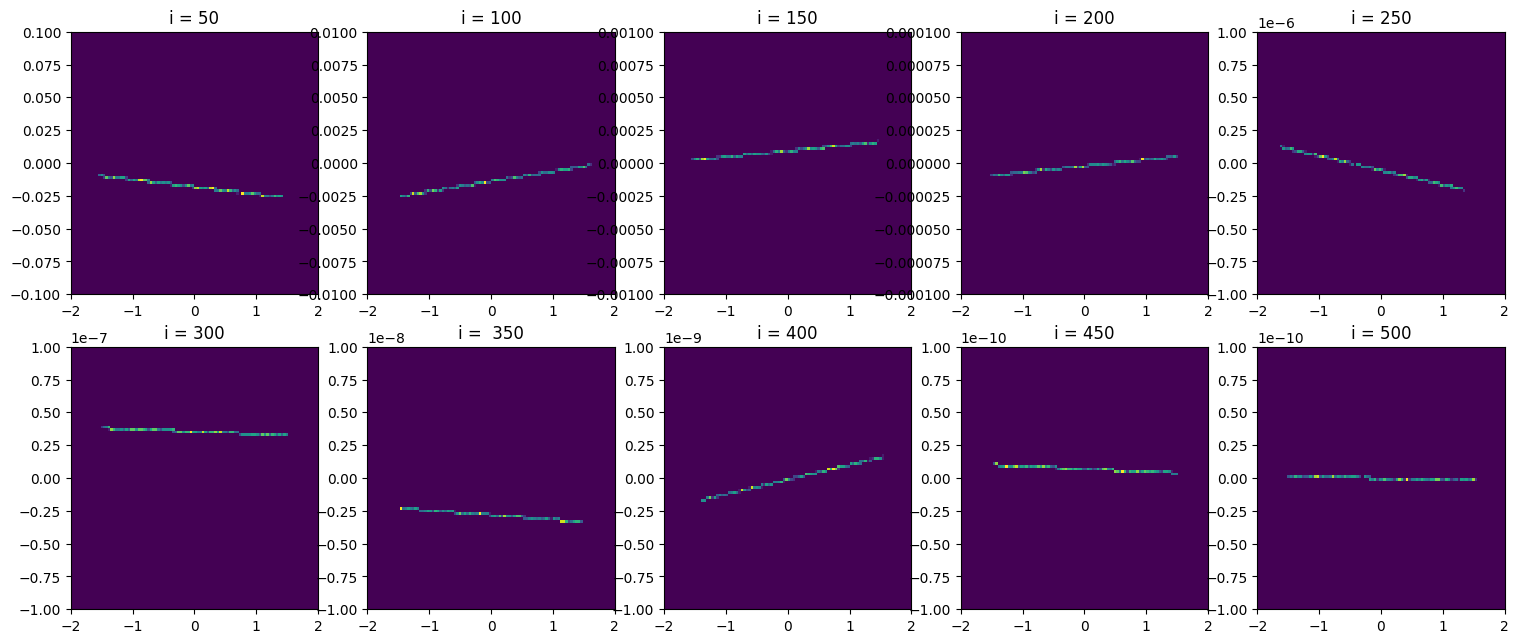

In [29]:
gamma = 0.1 #learning rate
n = 500

fig,((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(18.5, 7.5)

#Setting ADAM optimizer
theta = torch.tensor([[1.2,0.5], [-0.75, 0.2]], requires_grad = True) #arbitrary theta, we have theta[0] = a and theta[1] = b
adam = optim.Adam([theta], lr = gamma)

#parameters of the discrete mesure
y = torch.tensor([[-1,0], [1,0]])
nu = torch.tensor([1/2, 1/2])

list_x = np.empty((10, 500))
list_y = np.empty((10, 500))

for i in range(1, n + 1):
    ##ASGD method : We optimize w.r.t v
    v_tilde = torch.zeros(2) #initial v
    v = torch.zeros(2, dtype = torch.float32)
    #On échantillone des x avec la loi uniforme
    a = theta[0]
    b = theta[1]
    for j in range(1, n + 1) :
        x = torch.rand(1)
        g = a*x + (1 - x)*b
        l = torch.argmin(torch.tensor([c(g,y[0]) - v_tilde[0], c(g,y[1]) - v_tilde[1]]))
        one = torch.zeros(2)
        one[l] = 1
        grad = nu - one
        v_tilde = v_tilde + gamma/np.sqrt(j)*grad
        v = v_tilde/j + (j - 1)/n*v

    ##ADAM method : We optimize w.r.t theta
    adam.zero_grad()
    H_theta = H(theta, v.detach(), y, nu)
    H_theta.backward()
    adam.step()

    ##Sample from mu_theta
    if i%50 == 0:
        a = theta[0].detach()
        b = theta[1].detach()
        z = torch.rand(500)
        g = torch.empty(500,2)
        for j in range(500):
            g[j] = a*z[j] + (1 - z[j])*b
        list_x[i//50 - 1] = np.array(g[:,0])
        list_y[i//50 - 1] = np.array(g[:,1])

ax0.hist2d(list_x[0], list_y[0], 100, range = [[-2, 2], [-1e-1, 1e-1]])
ax0.set_title('i = 50')

ax1.hist2d(list_x[1], list_y[1], 100, range = [[-2, 2], [-1e-2, 1e-2]])
ax1.set_title('i = 100')

ax2.hist2d(list_x[2], list_y[2], 100, range = [[-2, 2], [-1e-3, 1e-3]])
ax2.set_title('i = 150')

ax3.hist2d(list_x[3], list_y[3], 100, range = [[-2, 2], [-1e-4, 1e-4]])
ax3.set_title('i = 200')

ax4.hist2d(list_x[4], list_y[4], 100, range = [[-2, 2], [-1e-6, 1e-6]])
ax4.set_title('i = 250')

ax5.hist2d(list_x[5], list_y[5], 100, range = [[-2, 2], [-1e-7, 1e-7]])
ax5.set_title('i = 300')

ax6.hist2d(list_x[6], list_y[6], 100, range = [[-2, 2], [-1e-8, 1e-8]])
ax6.set_title('i =  350')

ax7.hist2d(list_x[7], list_y[7], 100, range = [[-2, 2], [-1e-9, 1e-9]])
ax7.set_title('i = 400')

ax8.hist2d(list_x[8], list_y[8], 100, range = [[-2, 2], [-1e-10, 1e-10]])
ax8.set_title('i = 450')

ax9.hist2d(list_x[9], list_y[9], 100, range = [[-2, 2], [-1e-10, 1e-10]])
ax9.set_title('i = 500')

print('optimal theta is', theta)
print('optimal v is :', v)

Dans le cas où l'on se sert de l'ASGD de PyTorch.

optimal theta is tensor([[ 1.4969e+00,  8.0271e-23],
        [-1.4929e+00, -7.3343e-23]], requires_grad=True)
optimal v is : tensor([-0.0028,  0.0028], requires_grad=True)


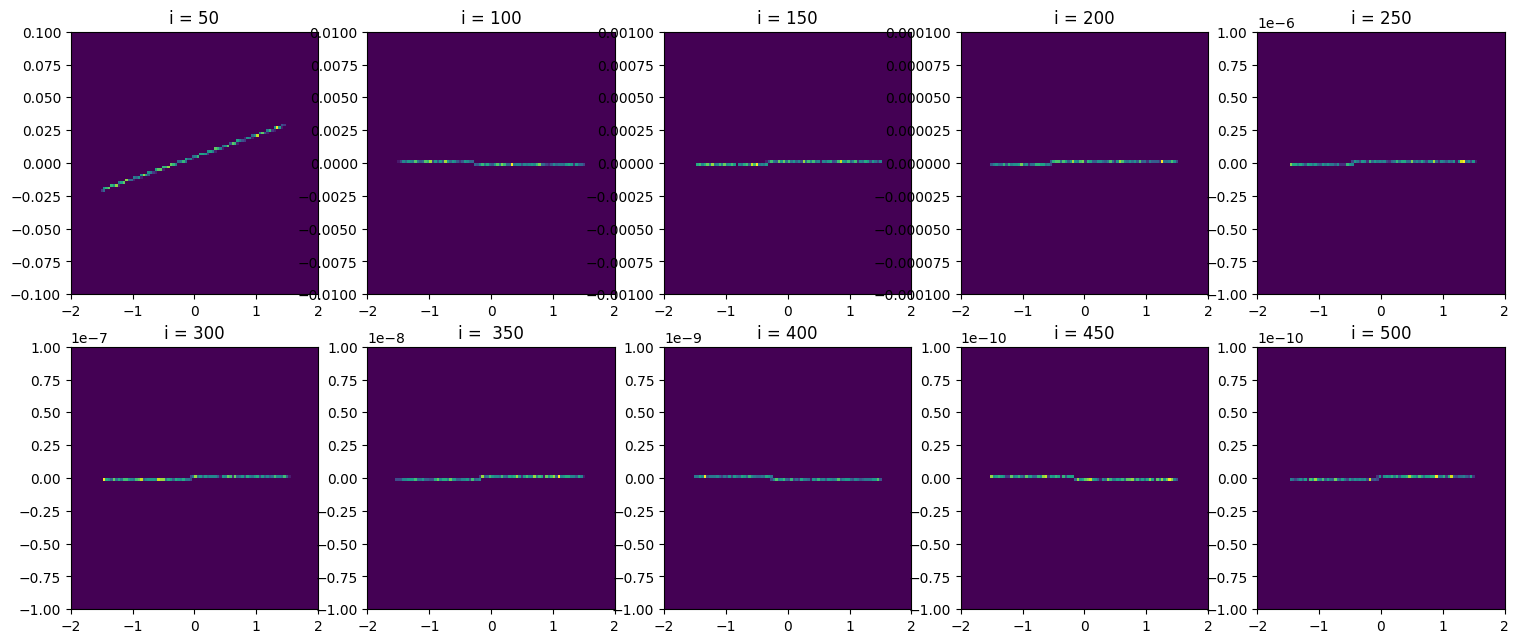

In [31]:
gamma = 0.01 #learning rate
n = 1000
fig,((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(18.5, 7.5)

#Setting ASGD optimizer
v = torch.zeros(2, requires_grad = True)
asgd = optim.ASGD([v], lr = gamma)

#Setting ADAM optimizer
theta = torch.tensor([[1,0.5], [-1, 0.2]], requires_grad = True) #arbitrary theta, we have theta[0] = a and theta[1] = b
adam = optim.Adam([theta], lr = gamma)

#parameters of the discrete mesure
y = torch.tensor([[-1,0], [1,0]])
nu = torch.tensor([1/2, 1/2])

list_x = np.empty((10, 500))
list_y = np.empty((10, 500))

for i in range(1, n + 1):
    ##ASGD method : We optimize w.r.t v
    asgd.zero_grad()
    loss = - H(theta.detach(), v, y, nu) #We want to maximize
    loss.backward()
    asgd.step()

    ##ADAM method : We optimize w.r.t theta
    adam.zero_grad()
    H_theta = H(theta, v.detach(), y, nu)
    H_theta.retain_grad
    H_theta.backward()
    adam.step()

    ##Sample from mu_theta
    if i%100 == 0:
        a = theta[0].detach()
        b = theta[1].detach()
        z = torch.rand(500)
        g = torch.empty(500,2)
        for j in range(500):
            g[j] = a*z[j] + (1 - z[j])*b
        list_x[i//100 - 1] = np.array(g[:,0])
        list_y[i//100 - 1] = np.array(g[:,1])

ax0.hist2d(list_x[0], list_y[0], 100, range = [[-2, 2], [-1e-1, 1e-1]])
ax0.set_title('i = 50')

ax1.hist2d(list_x[1], list_y[1], 100, range = [[-2, 2], [-1e-2, 1e-2]])
ax1.set_title('i = 100')

ax2.hist2d(list_x[2], list_y[2], 100, range = [[-2, 2], [-1e-3, 1e-3]])
ax2.set_title('i = 150')

ax3.hist2d(list_x[3], list_y[3], 100, range = [[-2, 2], [-1e-4, 1e-4]])
ax3.set_title('i = 200')

ax4.hist2d(list_x[4], list_y[4], 100, range = [[-2, 2], [-1e-6, 1e-6]])
ax4.set_title('i = 250')

ax5.hist2d(list_x[5], list_y[5], 100, range = [[-2, 2], [-1e-7, 1e-7]])
ax5.set_title('i = 300')

ax6.hist2d(list_x[6], list_y[6], 100, range = [[-2, 2], [-1e-8, 1e-8]])
ax6.set_title('i =  350')

ax7.hist2d(list_x[7], list_y[7], 100, range = [[-2, 2], [-1e-9, 1e-9]])
ax7.set_title('i = 400')

ax8.hist2d(list_x[8], list_y[8], 100, range = [[-2, 2], [-1e-10, 1e-10]])
ax8.set_title('i = 450')

ax9.hist2d(list_x[9], list_y[9], 100, range = [[-2, 2], [-1e-10, 1e-10]])
ax9.set_title('i = 500')

print('optimal theta is', theta)
print('optimal v is :', v)

On peut remarquer que le point optimal calculé dépend du $\theta^{\text{in}}$ utilisé. En effet, pour $\theta^{\text{in}} = [[1,0.5], [-1, 0.2]]$, on a $\theta^\star \approx [[1.5, 0], [-1.5, 0]]$ et $v^\star = [0.0036, -0.0036]$, tandis que pour $\theta^{\text{in}} = [[-1,0.5], [0.75, 1.25]]$, on trouve plutôt $\theta^\star \approx [[1, 0], [1, 0]]$, ce qui n'est bien entendu pas le bon résultat. Cela laisse à penser que l'algorithme n'est pas très stable vis-à-vis du $\theta$ initial que nous utilisons. Pour les autres paramètres, en particulier le learning rate, alors pour des valeurs modérés (entre $0.1$ et $1e-2$, l'algorithme converge sans problème). Cependant, pour des learning rate trop petit, en dessous de 0.01, il devient beaucoup plus long, même pour $n > 2000$, alors que $\gamma \in [0.1,0.01]$ garantit une très bonne précision en seulement 500 itérations.

On peut se convaincre que $\theta^\star = [[1.5, 0], [-1.5, 0]]$  est le bon résultat avec le dessin suivant

![title](intervalle.PNG)


Une autre remarque est que lorsqu'on optimise à la fois $\theta$ et $v$, on obtient un $v^\star$ anti-symétrique i.e $v_1^\star = - v_2^\star$, ce qui marque une première différence avec le résultat précédent. $v^\star$ n'était pas anti-symétrique lorsqu'on optimisait $v$ avec PyTorch sans toucher à $\theta$.

Des configurations de $\mu_{\theta}$ qui mènent des cas dégénérés existent, le plus simple qui vient immédiatement en tête est $\theta = 0$.

---
# Partie II

On télécharge les données MNIST

In [200]:
batch_size=1000
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)


Définition du générateur de MNIST.

Le generateur va passer de l'espace latent à l'espace des images $\mathcal{X}$. Il s'agira d'un réseau de neurone dont les poids seront les paramètres $\theta$ de notre distribution de probabilité $\mu_{\theta}$. Ainsi, la réponse du générateur, encore noté $g_{\theta}$, sera équivalent à échantilloner un élément de cette loi.




In [202]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )
    def forward(self, input):
        return self.main(input)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

Batch de 128 MNIST

In [223]:
real,labels = next(iter(train_loader))

Je vais stocker dans une liste $(10 \times 600)$ les positions des 6000 (sur les 60 000) MNIST dont j'ai besoin. Ces positions réfèrent à leur numéros d'apparition dans le tenseur train_set.
Il m'en faut 6000, dont 600 de chaques classes, je vais donc parcourir le tenseur jusqu'à avoir tout les MNIST dont j'ai besoin.

In [205]:
n_each = 6
N = n_each*10
pos_class = np.zeros((10,n_each))
count = np.ones(10)*n_each
i = 0
while np.any(count > 0):
  classes = labels[i]
  if count[classes] > 0:
    pos_class[classes][n_each - count[classes].astype(int)] = i
    count[classes] -= 1
  i += 1

La question maintenant est de savoir comment structurer l'espace latent. Et choisir les bons paramètres avec une bonne loi de prior. Je vais prendre de manière arbitraire $Z \rightsquigarrow \mathcal{N}(0,\mathbb{I})$ (même si d'après l'énoncé, $\mathcal{X}$ doit être à support compact), et prendre $\nu = \frac{1}{10}\sum_{i = 1}^{10}\delta_{y_i}$, où $y_i$ sera le barycentre empirique dans $\mathbb{R}^{28 \times 28}$ de chacune des classes, c'est-à-dire que l'on trie les MNIST par classe et qu'on l'on moyennise leur pixels. Autrement dit, on est dans le cas où $d = 28 \times 28 = 784$ ici.

Une autre possibilité est de prendre pour chaque image un vecteur $y_i$ de $\mathbb{R}^{28 \times 28}$. On a alors $\nu = \frac{1}{60}\sum_{i = 1}^{60} \delta_{y_i}$. Chaque classe sera représenté par 6 images. Une image est représentée par la donnée de chacun de ces pixels.

La loi de $Z$ pourrait être changé en soi, rien ne nous oriente plus vers une loi gaussienne qu'une autre.

Choisis ton format de donnée.

In [227]:
nu = torch.ones(N)*1/N
y_MNIST = torch.empty((10,n_each,1,28,28))
for i in range(10):
  y_MNIST[i] = real[pos_class[i]]
y_MNIST = y_MNIST.reshape(N,1,28,28)

In [234]:
nu = torch.ones(N)*1/N
y_MNIST = torch.empty((10,n_each,1,28,28))
for i in range(10):
  y_MNIST[i] = real[pos_class[i]]
y_MNIST = y_MNIST.reshape(N,28*28)

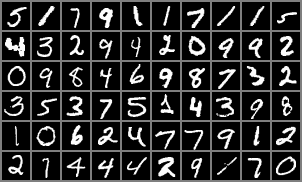

In [236]:
pil_img = imshow(torchvision.utils.make_grid(y_MNIST.reshape(N,1,28,28).to('cpu'),nrow=10))

In [219]:
# Recall the shape of the tensors at play:
#   x   (b , m)
#   y   (n,  m)
#   v   (n)
#
# In other words:
#   b: number of generated points (i.e. batch size)
#   n: number of data points
#   d: dimension of the data
#In this case : b = 128, n = 6000 and d = 28 x 28

def c_MNIST2(x,y):
    """
    Compute the squared euclidian distance between image x and y
    Args :
      x : Tensor of size d
      y : Tensor of size d
    Outputs :
    ||x - y||^2
    """
    diff = (x[None,:,:,:] - y)**2
    return torch.sum(diff, dim = (2,3))

def c_MNIST(x,y):
    """
    Compute the squared euclidian distance between x and y
    Args :
      x : Tensor of size d
      y : Tensor of size d
    Outputs :
    ||x - y||^2
    """
    return torch.sum((x - y)**2, axis = 1)

def c_transform(x,y,v):
    """
    Compute the c-transform of v at x in semi-discrete case
    Args :
      x : Location at which the  c-transform is evaluated (Tensor b x d)
      y : locations of the dirac measure in image-space (Tensor n x d)
      v : the vector whose c-transform is calculated (Tensor n)
    """
    C_transform = torch.empty(x.size()[0])
    for j in range(x.size()[0]):
      C_transform[j] = torch.min(c_MNIST(x[j], y) - v)
    return C_transform

def c_transform2(x,y,v):
    """
    Compute the c-transform of v at x in semi-discrete case
    Args :
      x : Location at which the  c-transform is evaluated (Tensor b x d)
      y : locations of the dirac measure in image-space (Tensor n x d)
      v : the vector whose c-transform is calculated (Tensor n)
    """
    C_transform = torch.empty(x.size()[0])
    for j in range(x.size()[0]):
      C_transform[j] = torch.min(c_MNIST2(x[j], y) - v)
    return C_transform

def H_MNIST(x, y, v, nu, Ni = 300):
    """
    Compute H i.e the expectation of H_tilde
    Args :
        x : output of the generator (float 784 x 1)
        v : point of evalutation of H (float 10 x 1)
        y : Location of the dirac of the discrete measure (float 784 x 1)
        nu : weight of the discrete measure (float 10 x 1)
        Ni : Number of samples to evaluate the integral (int)
    Outputs :
        Return H(v)
    """
    c_transf = c_transform(x,y,v)
    return torch.mean(c_transf) + torch.dot(nu,v) #The integral was calculated thanks to the batch

def H_MNIST2(x, y, v, nu, Ni = 300):
    """
    Compute H i.e the expectation of H_tilde
    Args :
        x : output of the generator (float 784 x 1)
        v : point of evalutation of H (float 10 x 1)
        y : Location of the dirac of the discrete measure (float 784 x 1)
        nu : weight of the discrete measure (float 10 x 1)
        Ni : Number of samples to evaluate the integral (int)
    Outputs :
        Return H(v)
    """
    c_transf = c_transform2(x,y,v)
    return torch.mean(c_transf) + torch.dot(nu,v) #The integral was calculated thanks to the batch

[30/300][60][206.7527 s]	Loss_G: 110.1177, 	Loss_D: -114.9100


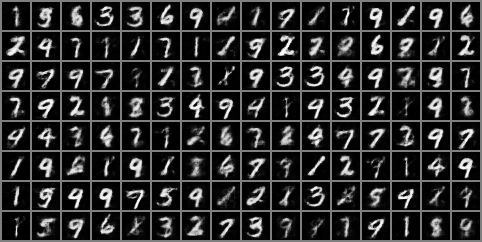

[60/300][60][420.5739 s]	Loss_G: 110.0115, 	Loss_D: -107.8717


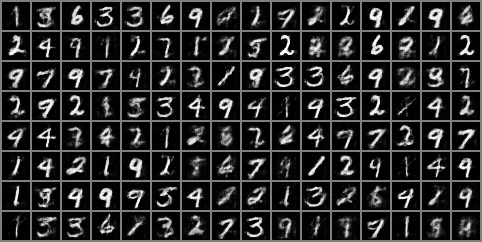

[90/300][60][633.7841 s]	Loss_G: 92.4958, 	Loss_D: -92.9892


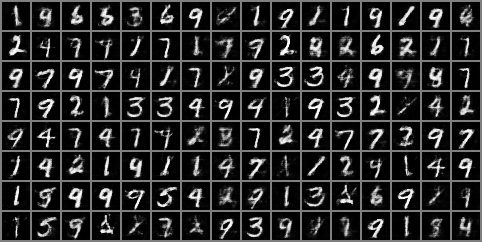

[120/300][60][867.9753 s]	Loss_G: 84.4574, 	Loss_D: -72.1945


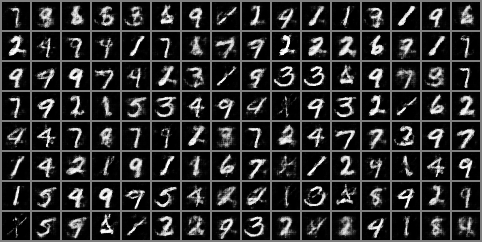

[150/300][60][1076.9078 s]	Loss_G: 81.2565, 	Loss_D: -86.7981


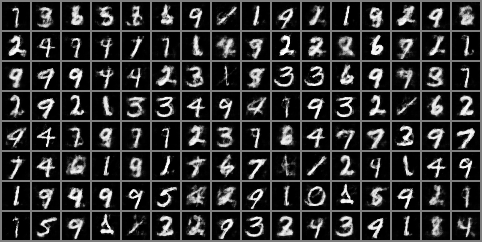

[180/300][60][1296.4707 s]	Loss_G: 84.1487, 	Loss_D: -88.8798


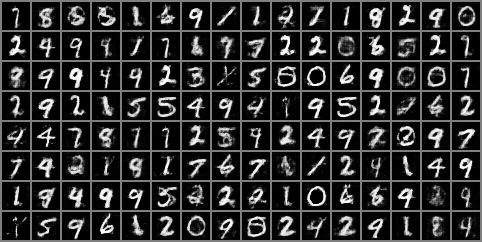

[210/300][60][1517.2490 s]	Loss_G: 77.0332, 	Loss_D: -92.5835


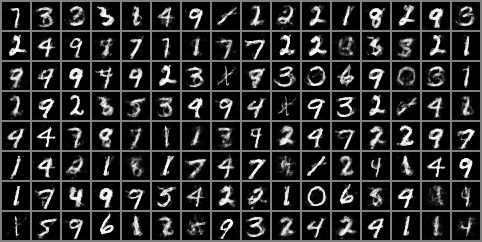

[240/300][60][1735.6999 s]	Loss_G: 72.6040, 	Loss_D: -71.5300


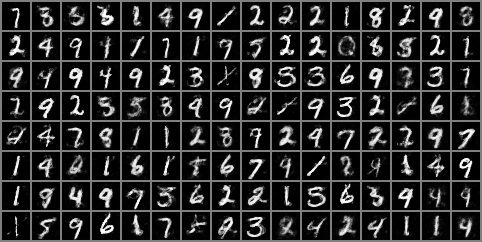

[270/300][60][1955.3224 s]	Loss_G: 70.6272, 	Loss_D: -89.8358


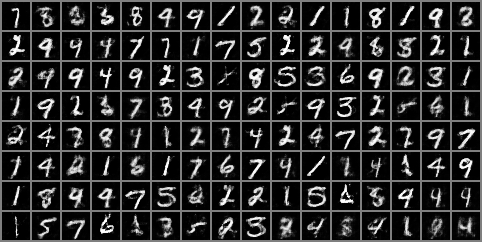

[300/300][60][2179.8232 s]	Loss_G: 68.6703, 	Loss_D: -81.4255


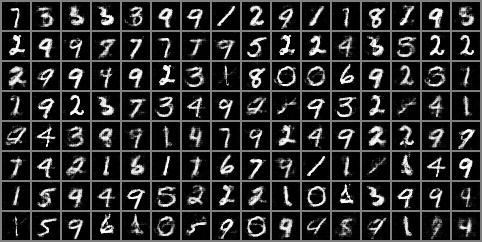

Total learning time =  2180.3924736976624


In [237]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 300
log_every = 30
gpw = 0.1

niterD=100
niterG=1

b_v = 10
b_gen = 100

#Initialization of v
v = torch.zeros(n_each*10, requires_grad = True)

G = Generator().to(device)
G.apply(weights_init);
optimG = optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
optimD = optim.ASGD([v], lr = 100, alpha = .5)

zviz = torch.randn(128,nz,1,1) #for vizualization

t0 = time.time()

for epoch in range(num_epochs):
    # For each batch in the train_loader
        ############################
    # Update D network
    for _ in range(1,niterD):
      optimD.zero_grad()
      z = torch.randn(b_v,nz,1,1)
      x = G(z)
      x = x.reshape(b_v,28*28)
      Dloss = - H_MNIST(x.detach(),y_MNIST,v,nu) #Maximize H w.r.t v
      Dloss.backward()
      optimD.step()

    #Generator step
    for _ in range(0,niterG):
      optimG.zero_grad()
      z = torch.randn(b_gen,nz,1,1)
      x = G(z)
      x = x.reshape(b_gen,28*28)
      Gloss = H_MNIST(x,y_MNIST,v.detach(),nu) #Minimize w.r.t theta
      Gloss.backward()
      optimG.step()
        ############################
    if (epoch+1)%log_every == 0:
      # Display training stats and visualize
      print('[%d/%d][%d][%.4f s]\tLoss_G: %.4f, \tLoss_D: %.4f'
            % (epoch+1, num_epochs, len(train_loader), time.time()-t0, Gloss.item(), Dloss.item()))
      show(G,zviz)

print('Total learning time = ',time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())

# Save final generator in a file
torch.save(G.state_dict(), 'wgan.pt')

On observe un mode collapse vers 1. Si on prend $\mathcal{Y}$ avec les barycentres (donc $|\mathcal{Y}| = 10$), on observe toujours un mode collapse mais vers 5 cette fois. La manière dont on pose le problème et dont $\mathcal{Y}$ est choisis influence fortement le comportement du WGAN semi-discret. Bien le choisir est central à mon sens pour éviter le mode collapse, car la géométrie des cellules de Laguerre résultantes y est directement impactée.

Dans le TP2, il y a une cellule où l'on entraîne le WGAN avec uniquement le générateur, et un discriminateur fixe. On observe que cela mène très rapidement à un mode collapse.

Je me suis donc dis qu'une des raisons du mode collapse était que le discriminateur était 'en retard' par rapport au générateur, qu'il n'évoluait pas assez vite. J'ai alors essayé un learning rate plus important pour le discriminateur que pour le générateur, mais cela n'a pas été concluant.

Une autre idée que j'ai eu aurait été de modifier les paramètres de la loi de $z$, en particulier d'augmenter sa variance. En effet, si on veut parcourir efficacement l'espace des images, et éviter un point attracteur, il pourrait être intéressant de mettre une plus grande variance, voire même de changer sa moyenne.

De manière générale, des learning rates entre $10^{-1}$ et $10^{-4}$ font converger sans problème l'algorithme, et n'ont pas vraiment d'influence sur le résultat obtenu. L'algorithme se comporte mieux tout de même quand le learning rate du discriminateur est plus élevé que celui du générateur.  